In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import os
import sys

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB


In [2]:
# parent_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
# sys.path.append(parent_dir)
# sys.path.append(os.path.abspath(os.path.join(parent_dir, '..')))

In [30]:
from models import *
from utilities import *

In [4]:
from natsort import natsorted

In [5]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)

# Data

In [6]:
b_dist = pd.read_csv('../data/balanced data for clf/tcremp_dists_TRB.txt', sep='\t', low_memory=False)
b_dist = b_dist.drop(columns = ['tcremp_id', 'cloneId'])
b_dist

,b_cdr3aa,b_v,b_j,b_0_v,b_0_j,b_0_cdr3,b_1_v,b_1_j,b_1_cdr3,b_2_v,...,b_2996_cdr3,b_2997_v,b_2997_j,b_2997_cdr3,b_2998_v,b_2998_j,b_2998_cdr3,b_2999_v,b_2999_j,b_2999_cdr3
0,CASSLGGSPLHF,TRBV5-4*01,TRBJ1-6*01,117.0,47.0,-120.0,135.0,44.0,-40.0,177.0,...,-100.0,337.0,44.0,-30.0,297.0,42.0,-160.0,132.0,42.0,40.0
1,CASSFGQGRTEAFF,TRBV5-6*01,TRBJ1-1*01,127.0,27.0,-30.0,138.0,46.0,-10.0,158.0,...,110.0,353.0,46.0,20.0,317.0,40.0,-40.0,131.0,40.0,-60.0
2,CASSGRGFLNYGYTF,TRBV5-6*01,TRBJ1-2*01,127.0,25.0,-60.0,138.0,43.0,-20.0,158.0,...,-180.0,353.0,43.0,-90.0,317.0,34.0,-110.0,131.0,34.0,10.0
3,CASSGRGFLNYGYTF,TRBV5-6*01,TRBJ1-2*01,127.0,25.0,-60.0,138.0,43.0,-20.0,158.0,...,-180.0,353.0,43.0,-90.0,317.0,34.0,-110.0,131.0,34.0,10.0
4,CASPGSVSNEQFF,TRBV5-4*01,TRBJ2-1*01,117.0,44.0,-110.0,135.0,59.0,-70.0,177.0,...,-110.0,337.0,59.0,-50.0,297.0,85.0,-70.0,132.0,85.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18259,CASSVARDRASTDTQYF,TRBV9*01,TRBJ2-3*01,121.0,49.0,-40.0,143.0,51.0,-90.0,168.0,...,-10.0,292.0,51.0,-30.0,493.0,62.0,-60.0,137.0,62.0,-10.0
18260,CASSLASGTPLDEQFF,TRBV11-2*01,TRBJ2-1*01,134.0,44.0,-70.0,105.0,59.0,-50.0,129.0,...,-50.0,187.0,59.0,-10.0,176.0,85.0,100.0,117.0,85.0,0.0
18261,CASSSRHSNQPQHF,TRBV13*01,TRBJ1-5*01,125.0,85.0,90.0,125.0,33.0,-60.0,154.0,...,-30.0,284.0,33.0,-40.0,273.0,44.0,-90.0,120.0,44.0,70.0
18262,CASSLVPGIAEAFF,TRBV14*01,TRBJ1-1*01,129.0,27.0,-160.0,103.0,46.0,-50.0,150.0,...,-50.0,189.0,46.0,50.0,178.0,40.0,-140.0,128.0,40.0,-60.0


In [7]:
# a_dist = pd.read_csv('../tcremp_a/tcremp_dists_TRA.txt', sep='\t', low_memory=False)
# a_dist = a_dist.drop(columns = ['tcremp_id', 'cloneId'])
# a_dist

In [8]:
b_dist.b_v = b_dist.b_v.apply(process_types)
b_dist.b_j = b_dist.b_j.apply(process_types)
# a_dist.a_j = a_dist.a_j.apply(process_types)

In [9]:
# av_minor = a_dist.a_v.value_counts()[a_dist.a_v.value_counts() < 200].index
# aj_minor = a_dist.a_j.value_counts()[a_dist.a_j.value_counts() < 200].index
bv_minor = b_dist.b_v.value_counts()[b_dist.b_v.value_counts() < 200].index
bj_minor = b_dist.b_j.value_counts()[b_dist.b_j.value_counts() < 200].index

In [10]:
# def preprocess_df(raw_dist_df, v, j, le_enc_v, le_enc_j, minor_genes_v=[], minor_genes_j=[]):
#     dist_df = raw_dist_df[~raw_dist_df[v].isin(minor_genes_v)]
#     dist_df = dist_df[~dist_df[j].isin(minor_genes_j)]
    
#     dist_df[v] = le_enc_v.fit_transform(dist_df[v])
#     dist_df[j] = le_enc_j.fit_transform(dist_df[j])
    
#     dist_df.iloc[:, 3:] = MinMaxScaler().fit_transform(dist_df.iloc[:, 3:])
    
#     return dist_df

In [11]:
b_v_enc = LabelEncoder()
b_j_enc = LabelEncoder()

In [16]:
b_dist_procssed, skaler = preprocess_df(b_dist, 'b_v', 'b_j', b_v_enc, b_j_enc, bv_minor, bj_minor)

In [17]:
from sklearn.model_selection import train_test_split

b_train, b_test = train_test_split(b_dist_procssed, test_size=0.2)

# Best model

In [18]:
b_train = b_train.drop(columns=['b_cdr3aa'])

In [19]:
b_train

,b_v,b_j,b_0_v,b_0_j,b_0_cdr3,b_1_v,b_1_j,b_1_cdr3,b_2_v,b_2_j,...,b_2996_cdr3,b_2997_v,b_2997_j,b_2997_cdr3,b_2998_v,b_2998_j,b_2998_cdr3,b_2999_v,b_2999_j,b_2999_cdr3
734,9,8,0.171504,0.400000,0.242857,0.191011,0.482759,0.190476,0.203057,0.400000,...,0.375000,0.223502,0.482759,0.263158,0.331019,0.549020,0.288462,0.192913,0.549020,0.279070
10289,8,10,0.469657,0.133333,0.271429,0.487640,1.000000,0.642857,0.194323,0.133333,...,0.196429,0.246544,1.000000,0.491228,0.222222,0.490196,0.250000,0.622047,0.490196,0.488372
16712,24,2,0.865435,0.066667,0.342857,0.559551,0.000000,0.500000,0.174672,0.066667,...,0.482143,0.198157,0.000000,0.315789,0.203704,0.019608,0.384615,0.917323,0.019608,0.279070
5516,17,1,0.073879,0.000000,0.400000,0.112360,0.344828,0.119048,0.794760,0.000000,...,0.250000,0.191244,0.344828,0.315789,0.189815,0.000000,0.250000,0.122047,0.000000,0.255814
4497,30,3,0.116095,0.316667,0.557143,0.186517,0.068966,0.261905,0.251092,0.316667,...,0.482143,0.529954,0.068966,0.280702,1.000000,0.117647,0.692308,0.204724,0.117647,0.232558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5886,6,8,0.166227,0.400000,0.342857,0.244944,0.482759,0.309524,0.233624,0.400000,...,0.464286,0.260369,0.482759,0.473684,0.187500,0.549020,0.230769,0.204724,0.549020,0.441860
15112,9,4,0.171504,1.000000,0.571429,0.191011,0.172414,0.238095,0.203057,1.000000,...,0.339286,0.223502,0.172414,0.157895,0.331019,0.196078,0.307692,0.192913,0.196078,0.255814
6110,12,5,0.638522,0.366667,0.585714,1.000000,0.362069,0.500000,0.155022,0.366667,...,0.321429,0.216590,0.362069,0.280702,0.189815,0.156863,0.403846,0.669291,0.156863,0.697674
983,21,10,0.105541,0.133333,0.400000,0.168539,1.000000,0.214286,0.270742,0.133333,...,0.392857,0.633641,1.000000,0.473684,0.546296,0.490196,0.423077,0.185039,0.490196,0.534884


In [20]:
# a_train = a_train.drop(columns=['a_cdr3aa'])

In [21]:
# hidden_layer_sizes=(100,), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000

In [22]:
n_v = b_dist_procssed.b_v.nunique()
n_j = b_dist_procssed.b_j.nunique()
inp_dim = b_train.shape[1] - 2

In [23]:
# from torch.utils.data import DataLoader

X = b_train.iloc[:, 2:]
y = b_train.iloc[:, 0:2]

In [24]:
b_test = b_test.drop(columns=['b_cdr3aa'])
X_test = b_test.iloc[:, 2:]
y_test = b_test.iloc[:, 0:2]

In [25]:
n_v = b_dist_procssed.b_v.nunique()
n_j = b_dist_procssed.b_j.nunique()
inp_dim = b_train.shape[1] - 2

In [26]:
# from torch.utils.data import DataLoader

X = b_train.iloc[:, 2:]
y = b_train.iloc[:, 0:2]

In [44]:
hidden = [1024, 512]
lr = 0.0001
n_drop = 0.2
n_epoches = 80

In [45]:
model = DecoderModelDropout(n_v = n_v, n_j = n_j, hidden_layer_sizes=hidden, lr=lr, n_drop=n_drop)
model.fit(X, y, n_epochs=n_epoches)

Epoch 1, Loss: 4.904783248901367
Epoch 2, Loss: 4.655993938446045
Epoch 3, Loss: 4.650486946105957
Epoch 4, Loss: 4.650572776794434
Epoch 5, Loss: 4.648736000061035
Epoch 6, Loss: 4.647815227508545
Epoch 7, Loss: 4.646276473999023
Epoch 8, Loss: 4.522759914398193
Epoch 9, Loss: 4.522477626800537
Epoch 10, Loss: 4.405241966247559
Epoch 11, Loss: 4.399543762207031
Epoch 12, Loss: 4.399511814117432
Epoch 13, Loss: 4.3993120193481445
Epoch 14, Loss: 4.40098762512207
Epoch 15, Loss: 4.401278495788574
Epoch 16, Loss: 4.156096935272217
Epoch 17, Loss: 4.155077934265137
Epoch 18, Loss: 4.156045913696289
Epoch 19, Loss: 4.15624475479126
Epoch 20, Loss: 4.157027244567871
Epoch 21, Loss: 4.15571928024292
Epoch 22, Loss: 4.15602445602417
Epoch 23, Loss: 4.156039714813232
Epoch 24, Loss: 4.15606164932251
Epoch 25, Loss: 4.155989170074463
Epoch 26, Loss: 4.156183242797852
Epoch 27, Loss: 4.155805587768555
Epoch 28, Loss: 4.157193660736084
Epoch 29, Loss: 4.155975341796875
Epoch 30, Loss: 4.155993461

In [46]:
losses = model.loss
losses_v = model.loss_v
losses_j = model.loss_j

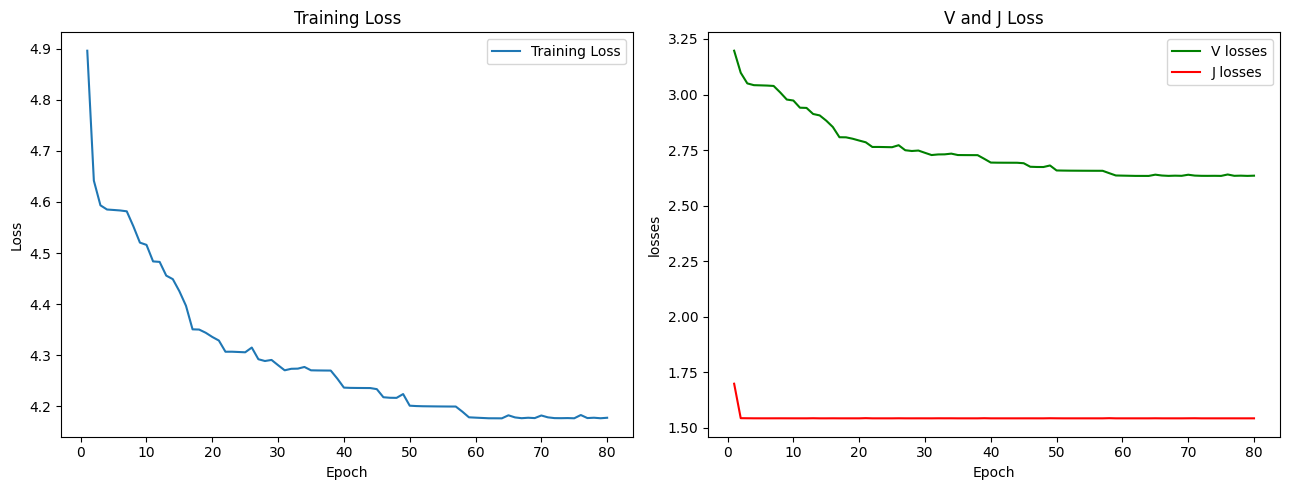

In [47]:
epochs = range(1, n_epoches + 1)

plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, losses_v, 'g-', label='V losses')
plt.plot(epochs, losses_j, 'r-', label='J losses')
plt.xlabel('Epoch')
plt.ylabel('losses')
plt.title('V and J Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [48]:
v_true, j_true = y_test.values.T

In [49]:
v_pred, j_pred = model.predict(X_test)

v_accuracy = accuracy_score(v_true, v_pred)
j_accuracy = accuracy_score(j_true, j_pred)

print(f"V Gene Accuracy: {v_accuracy}")
print(f"J Gene Accuracy: {j_accuracy}")

V Gene Accuracy: 0.8511227314672408
J Gene Accuracy: 1.0


In [50]:
from sklearn.metrics import f1_score

print(f"V Gene f1: {f1_score(v_true, v_pred, average='weighted'):.2f}")
print(f"J Gene f1: {f1_score(j_true, j_pred, average='weighted'):.2f}")


V Gene f1: 0.80
J Gene f1: 1.00


In [52]:
# torch.save(model.model.state_dict(), "model_parameters.pth")

In [38]:
# model = load_trained_model(inp_dim, n_v, n_j, hidden_layer_sizes=hidden, n_drop=n_drop)

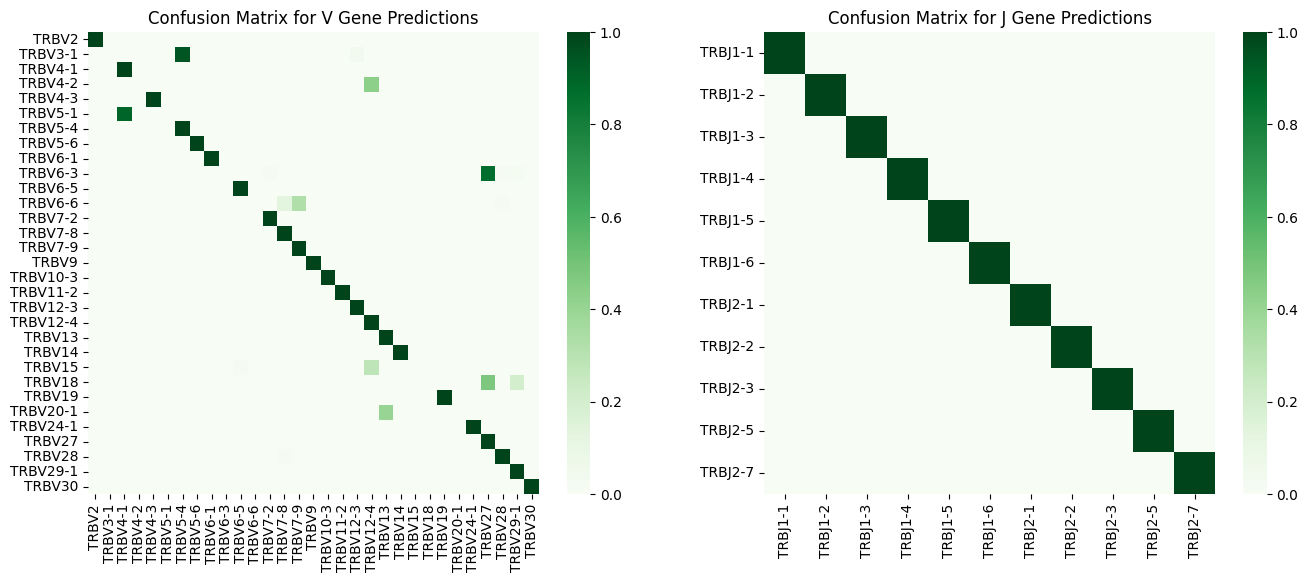

In [55]:
from sklearn.metrics import confusion_matrix

v_conf = confusion_matrix(v_true, v_pred)
j_conf = confusion_matrix(j_true, j_pred)

v_conf = MinMaxScaler().fit_transform(v_conf)
j_conf = MinMaxScaler().fit_transform(j_conf)

v_gene_names = b_v_enc.inverse_transform(b_dist_procssed.b_v.unique())#list(f'TRAV{i}' for i in range(1, 22))
j_gene_names = b_j_enc.inverse_transform(b_dist_procssed.b_j.unique())#["TRAJ1", "TRAJ2"]

df_v = pd.DataFrame(v_conf, index=v_gene_names, columns=v_gene_names)
df_v = df_v.reindex(index=natsorted(df_v.index, key=alphanumeric_sort))
df_v = df_v[natsorted(df_v.columns, key=alphanumeric_sort)]

df_j = pd.DataFrame(j_conf, index=j_gene_names, columns=j_gene_names)
df_j = df_j.reindex(index=natsorted(df_j.index, key=alphanumeric_sort))
df_j = df_j[natsorted(df_j.columns, key=alphanumeric_sort)]

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.heatmap(df_v, fmt="d", cmap="Greens")#, xticklabels=v_gene_names, yticklabels=v_gene_names)
plt.title("Confusion Matrix for V Gene Predictions")

plt.subplot(1, 2, 2)
sns.heatmap(df_j, fmt="d", cmap="Greens")
plt.title("Confusion Matrix for J Gene Predictions")
plt.savefig('../imgs/FCNN/Conf_matrix_VJ_pred_beta.png', bbox_inches='tight')